In [1]:
# import libraries
from pyopenms import *
import os

In [2]:
# change directory to find file of interest
os.chdir(r'C:\Users\miar\Desktop\data')

In [3]:
#------------------------------------------------------------------------------------------------------------------------------

# ONLY NEED TO RUN THE NEXT THREE BLOCKS ONCE

#-------------------------------------------------------------------------------------------------------------------------------

In [4]:
# load the content of the mzML file into the exp variable of type MSExperiment
#exp = MSExperiment()
#MzMLFile().load("HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP.mzML", exp)

# access the raw data and spectra
#spectrum_data = exp.getSpectrum(0).get_peaks()
#spectrum_data

In [5]:
# loop through the spectra to gather MS2 scans
#specM2 = []
#for s in exp.getSpectra():
#    if s.getMSLevel() == 2:
#        specM2.append(s)
        
#print("Number of MS2 scans: " + str(len(specM2)))

#exp.setSpectra(specM2) # keep only MS2

# store the modified data structure on disk
#MzMLFile().store("filtered_MS2.mzML", exp)

In [6]:
# loop through the spectra to gather MS3 scans
#specM3 = []
#for s in exp.getSpectra():
#    if s.getMSLevel() == 3:
#        specM3.append(s)
        
#print("Number of MS3 scans: " + str(len(specM3)))

#exp.setSpectra(specM3) # keep only MS3

# store the modified data structure on disk
#MzMLFile().store("filtered_MS3.mzML", exp)

In [7]:
# parse functions
def parseScanLine(input):
    x = input.split(" For: ")
    [scan_number, mzs] = x[1].split(", ")
    [precursor_mz, fragment_mz] = mzs.split(";")
    trimmed_fragment_mz = fragment_mz.strip() # trim fragment strings to remove \n
    return [scan_number, precursor_mz, trimmed_fragment_mz]

def parseTargetIons(input):
    i = input.split('Target Fragment: ')
    ion = i[1].split(',')[0]
    return ion 

In [8]:
# checking lines of log file and creating dictionary of scan numbers and fragment mzs
try:
  
    # words to search for
    search = ' Submitted Custom Scan For:'
    search_target = 'Target Fragment:'
    
    # dict for scan numbers and corresponding fragments 
    scan2frag = dict()
    target_values = []
    with open('App-2022-05-31_20-49-35.log') as f:
        for line in f:
            if search in line:
                scan_number, precursor_mz, trimmed_fragment_mz = parseScanLine(line)
                scan2frag[scan_number] = [float(precursor_mz), float(trimmed_fragment_mz)]
            elif search_target in line:
                target_ion = parseTargetIons(line)
                target_values.append(target_ion) #to add to final dataframe
            
    # if the input string doesn't exist in the text file
    if len(scan2frag)==0:
        print("\n\"" +search+ "\" is not found in \"" +'App-2022-05-31_20-49-35.log'+ "\"!")

except FileNotFoundError:
    print("The file does not exist!")

In [9]:
# load in MS2 scans
exp1 = MSExperiment()
MzMLFile().load("filtered_MS2.mzML", exp1)

In [10]:
# read in peptide sequence from tsv
import pandas as pd
tsv = pd.read_csv('HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP_realtimesearch1.tsv', sep='\t')

# create dictionary with scan # as key and sequence/charge as values
scan2PeptideCharge = dict([(i, [x,y]) for i, x,y, in zip(tsv['Scan Number'], tsv['Peptide'], tsv['Charge State'])])

# removing all NaN sequences (not useful)
scan2PeptideCharge_modified = {k:v for k,v in scan2PeptideCharge.items() if str(v[0]) != 'nan'}

In [11]:
def findFragments(peptide_object, charge):
    # loop through each prefix and suffix (b and y ions, respectively)
    # y and b ions

    b_index = []
    y_index = []
    for ion in range(1, (peptide_object.size())): # start at index of 1, end at peptide length - 1
        y_ion = peptide_object.getSuffix(ion)
        b_ion = peptide_object.getPrefix(ion)

        for z in range(1, charge):
            mz_b = b_ion.getMonoWeight(Residue.ResidueType.BIon, z) / z
            b_index.append(s.findNearest(mz_b, 0.4))

            mz_y = y_ion.getMonoWeight(Residue.ResidueType.YIon, z) / z
            y_index.append(s.findNearest(mz_y, 0.4))

    y_index.reverse() # reverse list (the first b ion corresponds with the last y ion)
    
    # skim list for each corresponding y and b fragments based on charge states
    count = 0
    missing_list = []
    for fragment_index in range(0, len(y_index), charge-1): # check after 'x' mzs (possible charge states)
        
        count = count + 1
        
        check_b = b_index[fragment_index : fragment_index+charge-1]
        check_y = y_index[fragment_index : fragment_index+charge-1]

        if all(item == -1 for item in check_b) and all(item == -1 for item in check_y):
            missing_list.append(str(count))
        
        number_missing = len(missing_list)
        missing_list_mod = ",".join(str(i) for i in missing_list)

    return missing_list_mod, number_missing

In [183]:
#from prettytable import PrettyTable 
#myTable = PrettyTable(["Scan Number", "Sequence", "Sequence Length", "Missing Fragment Locations"])

table_rows = []
for s in exp1:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
    
    if scan_number in scan2frag and int(scan_number) in scan2PeptideCharge_modified:
        # isolate peptide sequence from dict
        sequence = scan2PeptideCharge_modified[int(scan_number)][0]     
        trimmed_sequence = sequence[2:-2] # remove first two and last two characters 
        
        # isolate charge from dict
        charge = scan2PeptideCharge_modified[int(scan_number)][1]
 
        # create peptide object 
        peptide_object = AASequence.fromString(trimmed_sequence)
        
        # call findFragments function
        missing_list_mod, number_missing = findFragments(peptide_object, charge)
        
        # creating table
        #myTable.add_row([scan_number, trimmed_sequence, peptide_object.size(), missing_list])
        add_row = {'MS2_Scan_Number':scan_number, 
                'Sequence':trimmed_sequence,
                'Sequence_Length':peptide_object.size(),
                'Missing_Fragment_Locations':missing_list_mod,
                   'Number_Missing':number_missing}
        table_rows.append(add_row)

In [184]:
# add columns in df for precursor and fragment mzs (used later for MS3 matching)
precursor_mzs = []
for scan in list(scan2frag.keys()):
    precursor_mzs.append(scan2frag[scan][0])
    
fragment_mzs = []
for scan in list(scan2frag.keys()):
    fragment_mzs.append(scan2frag[scan][1])

In [185]:
# create dataframe to be exported as table later 
df = pd.DataFrame(table_rows)
# add targeted fragment column and precursor mz column
fragment_df = df.assign(Target_Fragment=target_values, Precursor_Mz=precursor_mzs, Fragment_Mz=fragment_mzs)

In [15]:
fragment_df[:10]

,Scan_Number,Sequence,Sequence_Length,Missing_Fragment_Locations,Number_Missing,Target_Fragment,Precursor_Mz,Fragment_Mz
0,2140,IFKNGSKRMIATVPLRHSIRD,21,13,1,y6,488.6834,392.2146
1,2534,RQVPLASPSSM[15.9949]SAALRGISCYLKE,24,"1,4,5,6,8,10,13,14,16,21,22,23",12,y5,660.8432,238.1160
2,3148,KAQAIIATMGGTTLMASAHSWAKSSSFSCPE,31,"1,2,3,4,6,8,9,11,13,15,18,19,20,21,22,23,24,26...",22,b4,807.6348,200.1212
3,3582,KSSM[15.9949]KRKLPFTISPSRNE,18,"3,4,6,10,11,13,14,16",8,y3,531.5447,140.0730
4,3716,AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE,39,"1,2,3,5,6,8,9,12,14,15,18,24,26,28,32,34,36,38",18,b4,733.1652,130.0598
5,4057,MASCAEPSEPSAPLPAGVPPLE,22,"4,5,7,10,14,15,16,20",8,b2,737.0179,203.0849
6,4068,KLM[15.9949]QLNLCSNRLE,13,"2,6",2,y4,545.9495,531.2885
7,4111,RFNHFSLTLNTNHGHILVD,19,"1,2,16,17",4,y4,559.5391,459.2813
8,4149,RRYCNSHLQVLGFIPKKE,18,"1,2,7",3,y4,562.0572,501.3031
9,4150,KPATDPVLQVVYKSQGKE,18,"3,5,7,12,15",5,b6,663.7004,610.3195


In [16]:
# export df to tsv 
#fragment_df.to_csv('fragmentInfoTable.tsv', sep=' ', index=False)

In [17]:
# perform table modifications and plot histograms in R...
# ...
# ...

In [18]:
# read in modified table
checktargets_df = pd.read_csv('fragmentInfoTable_altered.tsv', sep="/t", engine='python')

In [19]:
# peek at the first 20 rows for manually checking if subsequent code has expected output
checktargets_df.loc[:10]

,"""Scan_Number""","""Sequence""","""Sequence_Length""","""nTerminusEnd""","""Number_Missing""","""Target_Fragment""","""cTerminusEnd"""
0,2140,"""IFKNGSKRMIATVPLRHSIRD""",21,13.0,1,"""y6""",8.0
1,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,1.0,12,"""y5""",23.0
2,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,4.0,12,"""y5""",20.0
3,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,5.0,12,"""y5""",19.0
4,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,6.0,12,"""y5""",18.0
5,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,8.0,12,"""y5""",16.0
6,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,10.0,12,"""y5""",14.0
7,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,13.0,12,"""y5""",11.0
8,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,14.0,12,"""y5""",10.0
9,2534,"""RQVPLASPSSM[15.9949]SAALRGISCYLKE""",24,16.0,12,"""y5""",8.0


In [20]:
yes = []
no = []
for i in checktargets_df.index:
    if checktargets_df['"Target_Fragment"'][i].startswith('"y'):
        if str(checktargets_df.loc[i]['"cTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"cTerminusEnd"'][i]):
            yes.append('Yes, the target y ion could help us find the missing fragment')
            #print('Yes, the target y ion could help us find the missing fragment')
        else:
            no.append('No...the target y ion does not help us')
            #print('No...the target y ion does not help us')
    elif checktargets_df['"Target_Fragment"'][i].startswith('"b'):
        if str(checktargets_df.loc[i]['"nTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"nTerminusEnd"'][i]):
            yes.append('Yes, the target b ion could help us find the missing fragment')
            #print('Yes, the target b ion could help us find the missing fragment')
        else: 
            no.append('No...the target b ion does not help us')
            #print('No...the target b ion does not help us')
            
            

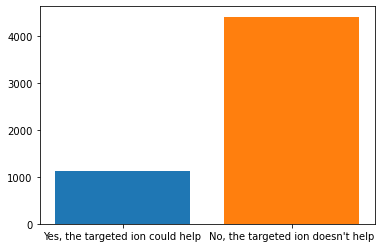

In [21]:
import matplotlib.pyplot as plt
plt.bar('Yes, the targeted ion could help', len(yes))
plt.bar('No, the targeted ion doesn\'t help', len(no))
plt.show()

In [22]:
# load in MS3 scans
exp2 = MSExperiment()
MzMLFile().load("filtered_MS3.mzML", exp2)

In [81]:
# obtain precursor and fragment mzs from the spectrum

ms3scan2PrecursorMZ = dict()
ms3scan2FragmentMZ = dict()
for s in exp2:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
   
    fragment, precursor = s.getPrecursors()
    precursor_mz = precursor.getMZ()
    fragment_mz = fragment.getMZ()
    
    ms3scan2PrecursorMZ[int(scan_number)] = round(float(precursor_mz), 4) # 4 decimal places, similar to log
    ms3scan2FragmentMZ[scan_number] = round(float(fragment_mz), 4)

In [186]:
def matchingMS3s(which_dict, which_mz_list, type_str): # either fragment or precursor
    
    # do they not match off the bat?
    if list(which_dict.values()) != which_mz_list:
        
        # taking into consideration rounding discrepencies between the log and the spectrum
        mismatch = []
        for i in range(0, len(which_mz_list)):
            diff = float(list(which_dict.values())[i]) - float(which_mz_list[i]) 
            if diff < 0.00011 or (diff < 0 and diff > -0.00011):
                pass
            else:
                mismatch.append(i)
        if len(mismatch) == 0:
            print(type_str + ' match up after taking rounding discrepencies into consideration')
            new_fragment_df = fragment_df.assign(MS3_Scan_Number = list(which_dict.keys()))
        else:
            print('There is mismatch at the following indicies:') # if this is the case, need to do more work...
            for i in mismatch:
                print(i) 
      
    # they match perfectly
    elif list(which_dict.values()) == which_mz_list:
        if 
        print(type_str + ' match up perfectly!')
        new_fragment_df = fragment_df.assign(MS3_Scan_Number = list(which_dict.keys()))

    return new_fragment_df

In [197]:
# integrate into above function to ensure MS3 is found within 100 scans of MS2
for ms2scan, ms3scan in zip(list(scan2frag.keys()), list(ms3scan2FragmentMZ)):
    scan_diff = int(ms3scan) - int(ms2scan)
    if scan_diff > 100:
        print('yikes')

In [187]:
# matching precursor mzs between MS2 (log) and MS3 (spectrum)
matchingMS3s(ms3scan2PrecursorMZ, precursor_mzs, 'Precursor mzs')

Precursor mzs match up after taking rounding discrepencies into consideration


,MS2_Scan_Number,Sequence,Sequence_Length,Missing_Fragment_Locations,Number_Missing,Target_Fragment,Precursor_Mz,Fragment_Mz,MS3_Scans
0,2140,IFKNGSKRMIATVPLRHSIRD,21,13,1,y6,488.6834,392.2146,2148
1,2534,RQVPLASPSSM[15.9949]SAALRGISCYLKE,24,"1,4,5,6,8,10,13,14,16,21,22,23",12,y5,660.8432,238.1160,2543
2,3148,KAQAIIATMGGTTLMASAHSWAKSSSFSCPE,31,"1,2,3,4,6,8,9,11,13,15,18,19,20,21,22,23,24,26...",22,b4,807.6348,200.1212,3158
3,3582,KSSM[15.9949]KRKLPFTISPSRNE,18,"3,4,6,10,11,13,14,16",8,y3,531.5447,140.0730,3585
4,3716,AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE,39,"1,2,3,5,6,8,9,12,14,15,18,24,26,28,32,34,36,38",18,b4,733.1652,130.0598,3727
...,...,...,...,...,...,...,...,...,...
2722,80065,IAPFLCHPNLWIRYGAVGFITVVARQISTAD,31,"5,8,12,13,14,16,21,23,27,28,29,30",12,y6,1163.2990,317.6558,80071
2723,80148,FKMHKKGYNRHNQCLTTSHSKIFQCD,26,19,1,b3,817.8955,136.4086,80156
2724,80485,LTLLAFALARGSVAKVMSSLCTITD,25,"2,8,13,24",4,b6,660.6157,660.4160,80493
2725,80530,IVNSLQKM[15.9949]QNKGGGD,15,"6,11",2,b2,803.4066,213.1598,80536


In [188]:
# matching fragment mzs between MS2 (log) and MS3 (spectrum)
matchingMS3s(ms3scan2FragmentMZ, fragment_mzs, 'Fragment mzs')

Fragment mzs match up perfectly!


,MS2_Scan_Number,Sequence,Sequence_Length,Missing_Fragment_Locations,Number_Missing,Target_Fragment,Precursor_Mz,Fragment_Mz,MS3_Scans
0,2140,IFKNGSKRMIATVPLRHSIRD,21,13,1,y6,488.6834,392.2146,2148
1,2534,RQVPLASPSSM[15.9949]SAALRGISCYLKE,24,"1,4,5,6,8,10,13,14,16,21,22,23",12,y5,660.8432,238.1160,2543
2,3148,KAQAIIATMGGTTLMASAHSWAKSSSFSCPE,31,"1,2,3,4,6,8,9,11,13,15,18,19,20,21,22,23,24,26...",22,b4,807.6348,200.1212,3158
3,3582,KSSM[15.9949]KRKLPFTISPSRNE,18,"3,4,6,10,11,13,14,16",8,y3,531.5447,140.0730,3585
4,3716,AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE,39,"1,2,3,5,6,8,9,12,14,15,18,24,26,28,32,34,36,38",18,b4,733.1652,130.0598,3727
...,...,...,...,...,...,...,...,...,...
2722,80065,IAPFLCHPNLWIRYGAVGFITVVARQISTAD,31,"5,8,12,13,14,16,21,23,27,28,29,30",12,y6,1163.2990,317.6558,80071
2723,80148,FKMHKKGYNRHNQCLTTSHSKIFQCD,26,19,1,b3,817.8955,136.4086,80156
2724,80485,LTLLAFALARGSVAKVMSSLCTITD,25,"2,8,13,24",4,b6,660.6157,660.4160,80493
2725,80530,IVNSLQKM[15.9949]QNKGGGD,15,"6,11",2,b2,803.4066,213.1598,80536
